## Imports & Configuration


In [ ]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


DATA_IN = "//content/Surge_Updated_File_Corrected.xlsx"
DATA_OUT = "/content/FixRoute_With_ETA_GB.xlsx"
MODEL_OUT = "/content/eta_gb_model.joblib"


MAPBOX_TOKEN = "pk.eyJ1IjoiY2hhdDEyMyIsImEiOiJjbWk0ZDljNjgxZWJwMmpzZmdsbGo1Y2hzIn0.Gsz2y11JR9GfLcpEb58K_Q"

df = pd.read_excel(DATA_IN)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Request_ID                   1000 non-null   object 
 1   User_ID                      1000 non-null   object 
 2   User_Name                    1000 non-null   object 
 3   User_Phone                   1000 non-null   int64  
 4   User_Location                1000 non-null   object 
 5   User_to_Technician_Distance  1000 non-null   float64
 6   Estimated_Delivery_Time      1000 non-null   float64
 7   Vehicle_Company              1000 non-null   object 
 8   Vehicle_Model                1000 non-null   object 
 9   Model_Year                   1000 non-null   int64  
 10  Service_Name                 1000 non-null   object 
 11  Service_Description          1000 non-null   object 
 12  Spare_Part_Name              1000 non-null   object 
 13  Spare_Part_Price   

In [ ]:
df[df.duplicated()]

,Request_ID,User_ID,User_Name,User_Phone,User_Location,User_to_Technician_Distance,Estimated_Delivery_Time,Vehicle_Company,Vehicle_Model,Model_Year,...,Estimated_arrival_time_ETA,Past_performance_ratings,Total_Price,Final_Price,User_Lat,User_Lng,Tech_Lat,Tech_Lng,Road_Distance,Road_Duration


## 1. ETA Estimation

##  Mapbox Distance & ETA Function

In [ ]:
def mapbox_distance_time(lat1, lon1, lat2, lon2):
    url = f"https://api.mapbox.com/directions/v5/mapbox/driving/{lon1},{lat1};{lon2},{lat2}"
    params = {
        "access_token": MAPBOX_TOKEN,
        "geometries": "geojson",
        "overview": "simplified"
    }

    r = requests.get(url, params=params)
    data = r.json()

    try:
        dist = data["routes"][0]["distance"] / 1000
        eta = data["routes"][0]["duration"] / 60
        return dist, eta
    except:
        return np.nan, np.nan


## Build ETA Input DataFrame

In [ ]:
eta_df = pd.DataFrame({
    "user_lat": df["User_Lat"],
    "user_lng": df["User_Lng"],
    "tech_lat": df["Tech_Lat"],
    "tech_lng": df["Tech_Lng"],
    "road_condition": df["Road_conditions"],
    "time_of_day": df["Time_of_day"]
})


## Map Categorical Columns





In [ ]:
time_map = {"Morning": 9, "Afternoon": 15, "Evening": 19, "Night": 22}
road_map = {"Good": 3, "Average": 2, "Bad": 1}

eta_df["hour_of_day"] = eta_df["time_of_day"].map(time_map)
eta_df["road_condition"] = eta_df["road_condition"].map(road_map)
eta_df.drop(columns=["time_of_day"], inplace=True)


## Fetch Distance & ETA via Mapbox

In [ ]:
distances = []
durations = []

for _, row in eta_df.iterrows():
    d, t = mapbox_distance_time(
        row["user_lat"], row["user_lng"],
        row["tech_lat"], row["tech_lng"]
    )
    distances.append(d)
    durations.append(t)

eta_df["mapbox_distance_km"] = distances
eta_df["mapbox_eta_minutes"] = durations
eta_df.dropna(inplace=True)


## Gradient Boosting ETA Model

In [ ]:
X = eta_df[[
    "user_lat", "user_lng",
    "tech_lat", "tech_lng",
    "road_condition", "hour_of_day"
]]
y = eta_df["mapbox_eta_minutes"]

model = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4
)

model.fit(X, y)
joblib.dump(model, MODEL_OUT)


['/content/eta_gb_model.joblib']

## Save Final Output File

In [ ]:
df["Final_Distance_KM"] = eta_df["mapbox_distance_km"].values
df["Final_ETA_Minutes"] = model.predict(X)

df.to_excel(DATA_OUT, index=False)



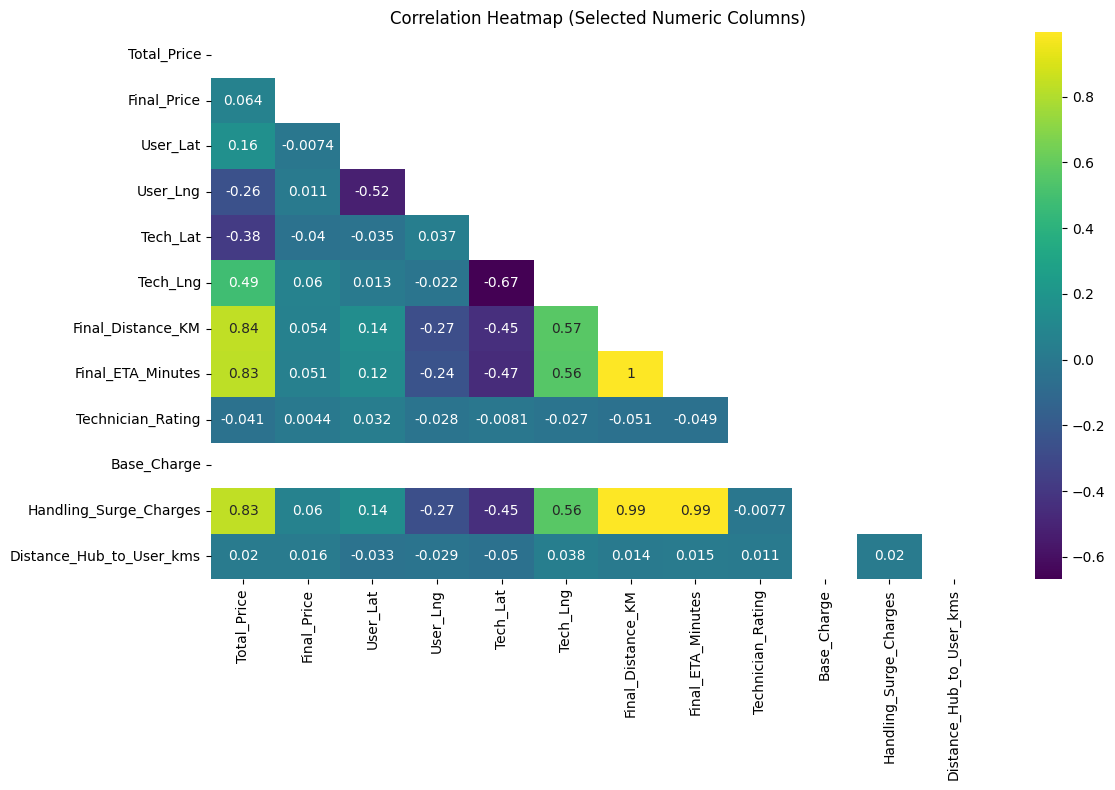

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel("/content/FixRoute_With_ETA_GB.xlsx")

# Step 1: Columns you want to select
cols = [
    "Total_Price",
    "Final_Price",
    "User_Lat",
    "User_Lng",
    "Tech_Lat",
    "Tech_Lng",
    "Final_Distance_KM",
    "Final_ETA_Minutes",
    "Technician_Rating",
    "Base_Charge",
    "Handling_Surge_Charges",
    "Distance_Hub_to_User_kms"
]

# Step 2: Select only existing + numeric columns
df_sub = df[cols].select_dtypes(include=['int64', 'float64'])

# Step 3: Compute correlation + mask
corr = df_sub.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Step 4: Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='viridis', mask=mask)
plt.title("Correlation Heatmap (Selected Numeric Columns)")
plt.tight_layout()
plt.show()


In [ ]:
display(round(df[['Final_Distance_KM', 'Handling_Surge_Charges']].corr(),2))


,Final_Distance_KM,Handling_Surge_Charges
Final_Distance_KM,1.00,0.99
Handling_Surge_Charges,0.99,1.00


<Axes: >

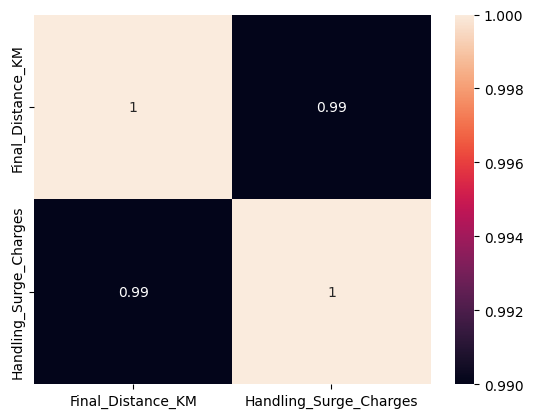

In [ ]:
sns.heatmap(round(df[['Final_Distance_KM', 'Handling_Surge_Charges']].corr(),2), annot=True)


In [ ]:
display(round(df[['Final_ETA_Minutes', 'Handling_Surge_Charges']].corr(),2))


,Final_ETA_Minutes,Handling_Surge_Charges
Final_ETA_Minutes,1.00,0.99
Handling_Surge_Charges,0.99,1.00


<Axes: >

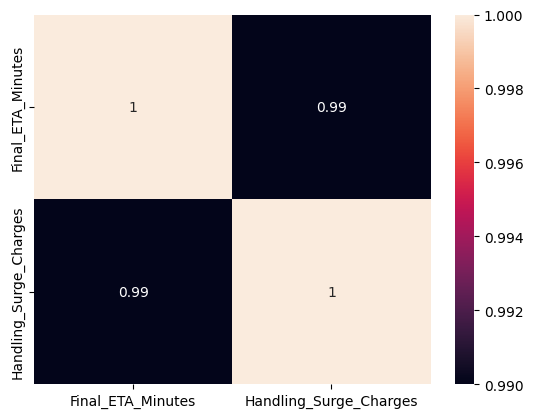

In [ ]:
sns.heatmap(round(df[['Final_ETA_Minutes', 'Handling_Surge_Charges']].corr(),2), annot=True)


In [ ]:
display(round(df[['Technician_Rating', 'Handling_Surge_Charges']].corr(),2))


,Technician_Rating,Handling_Surge_Charges
Technician_Rating,1.00,-0.01
Handling_Surge_Charges,-0.01,1.00


<Axes: >

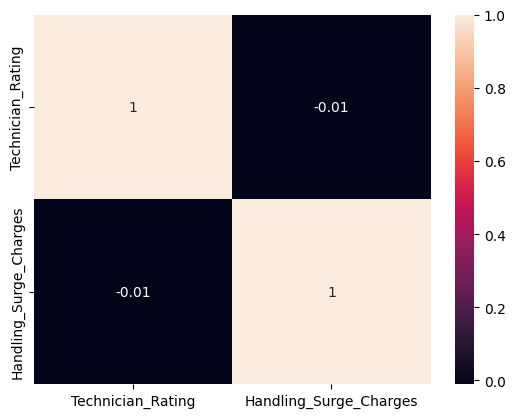

In [ ]:
sns.heatmap(round(df[['Technician_Rating', 'Handling_Surge_Charges']].corr(),2), annot=True)



Insights :
1. Distance strongly drives price
Longer trips increase both the total price and the time taken.
2. Surge charges rise almost directly with trip distance and ETA
3. technician rating has no effect on pricing
4. Ratings don’t impact price, surge, distance, or travel time.





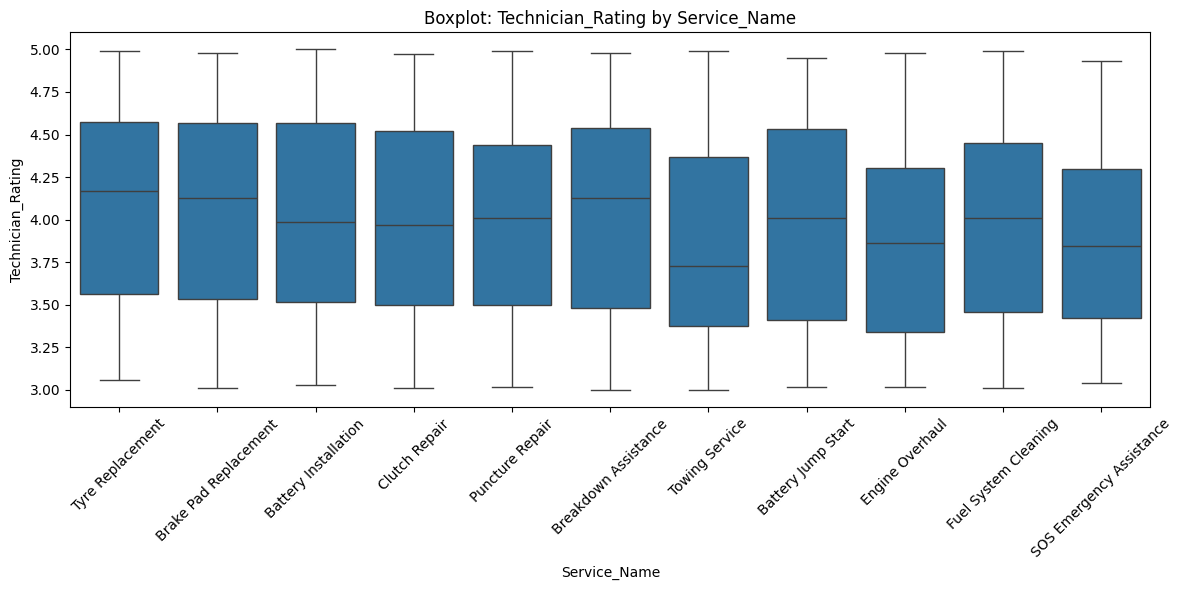

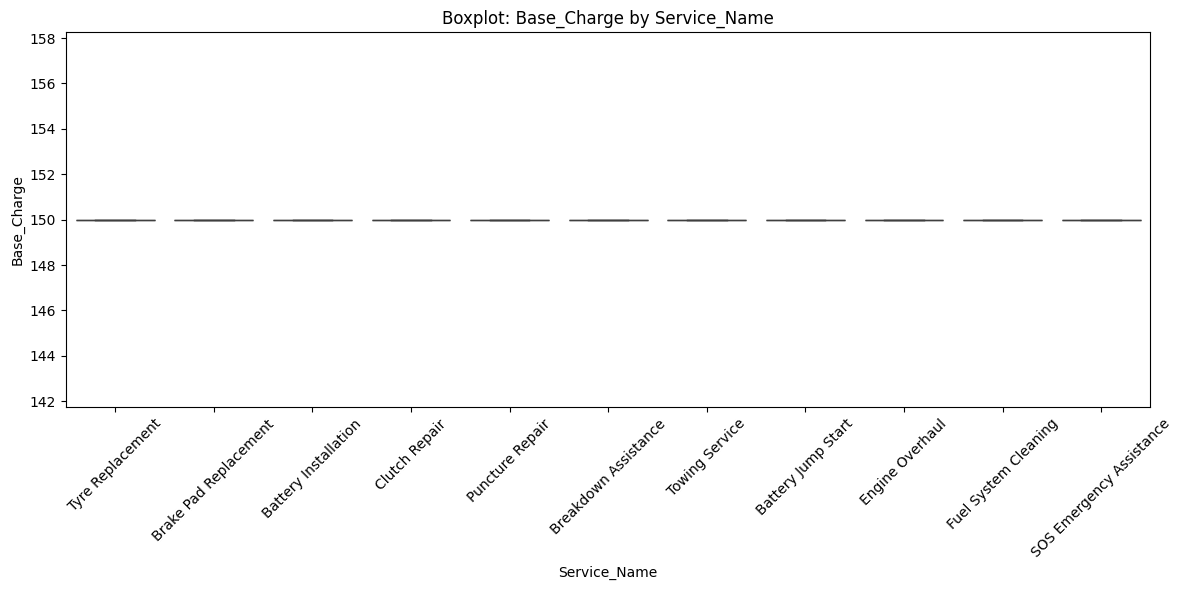

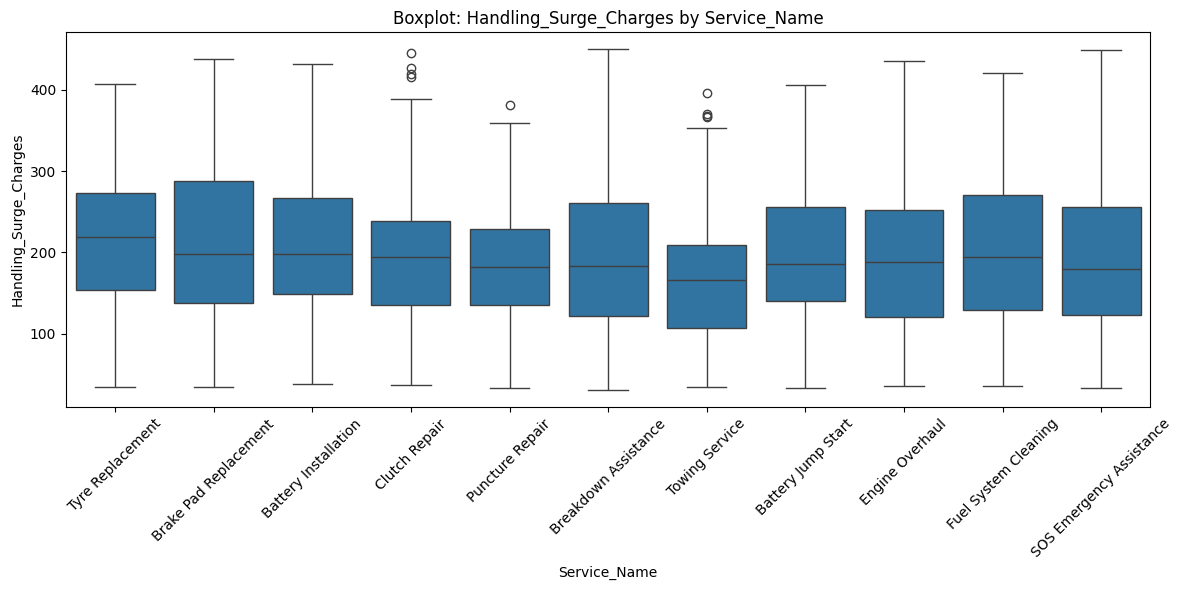

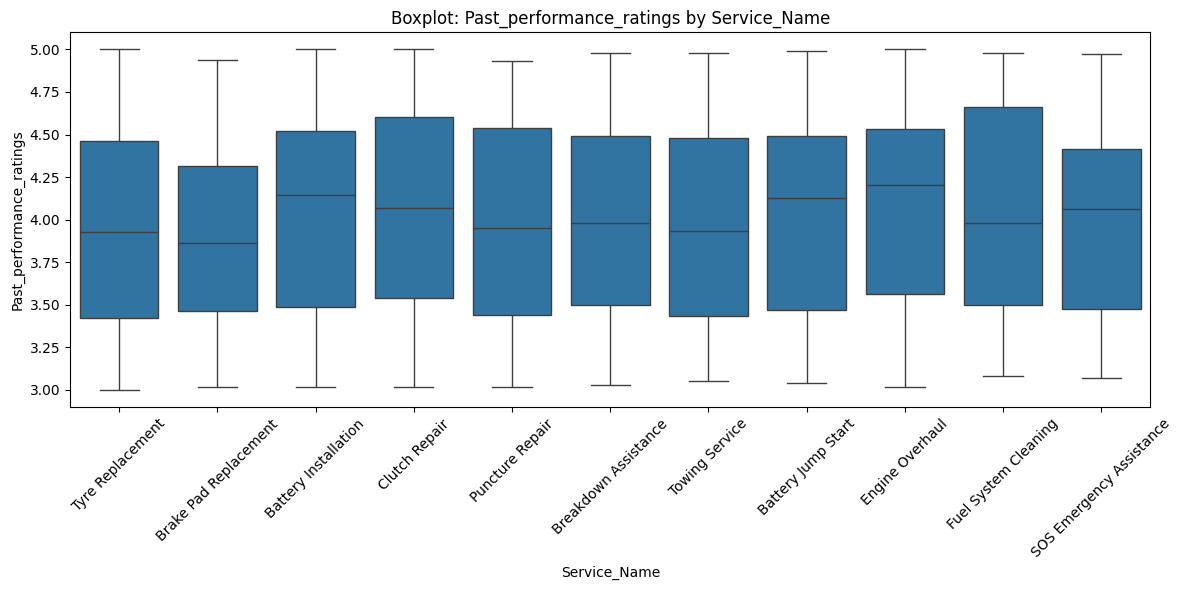

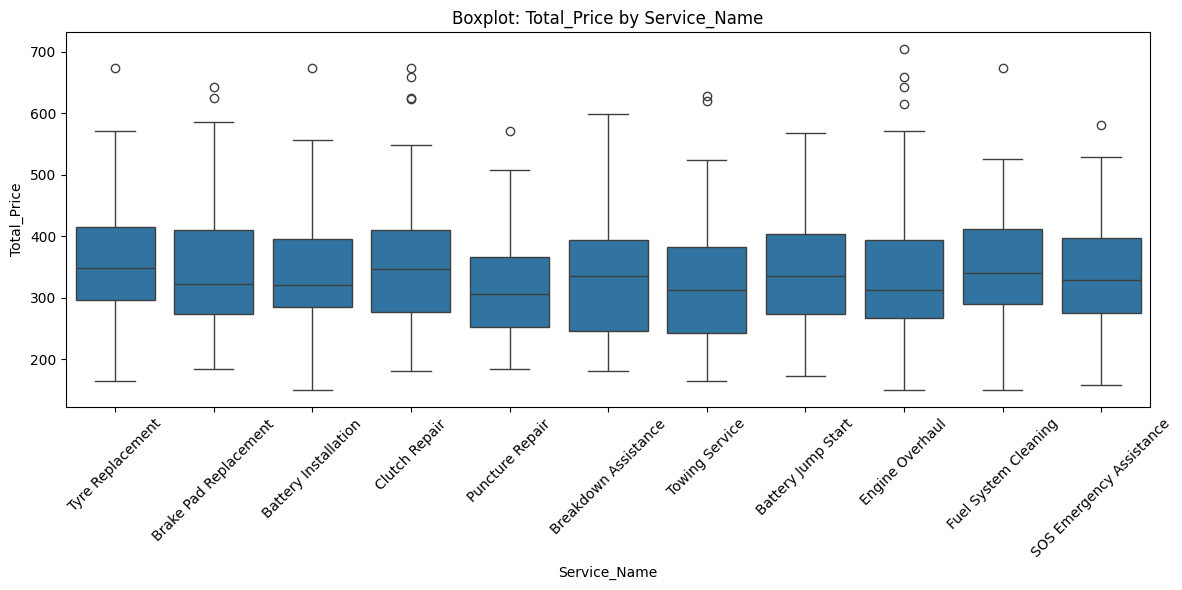

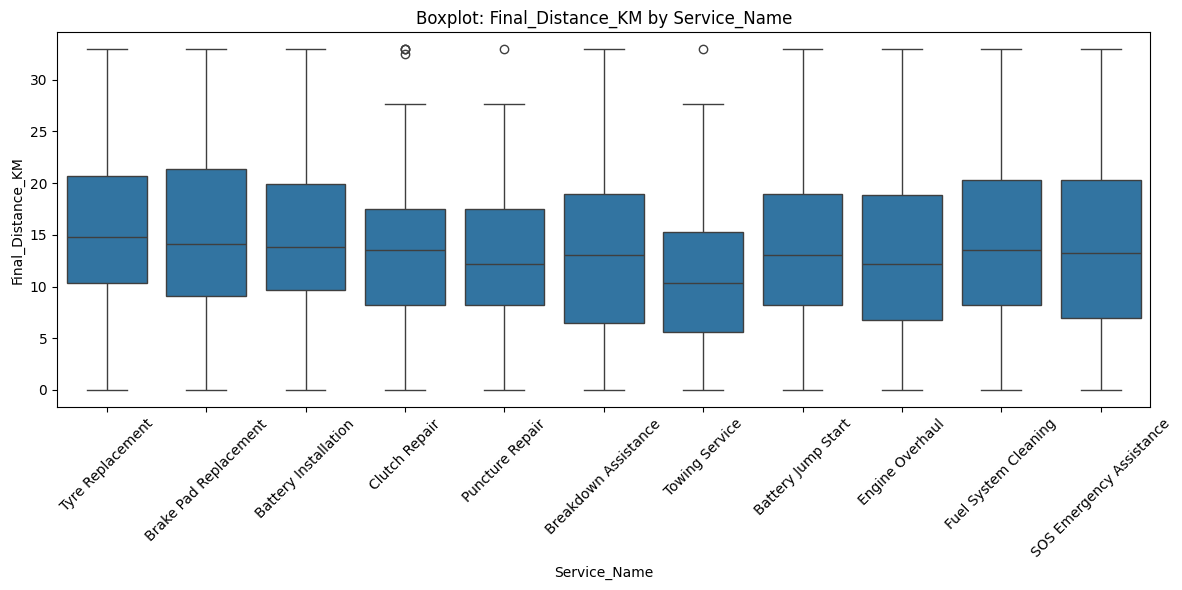

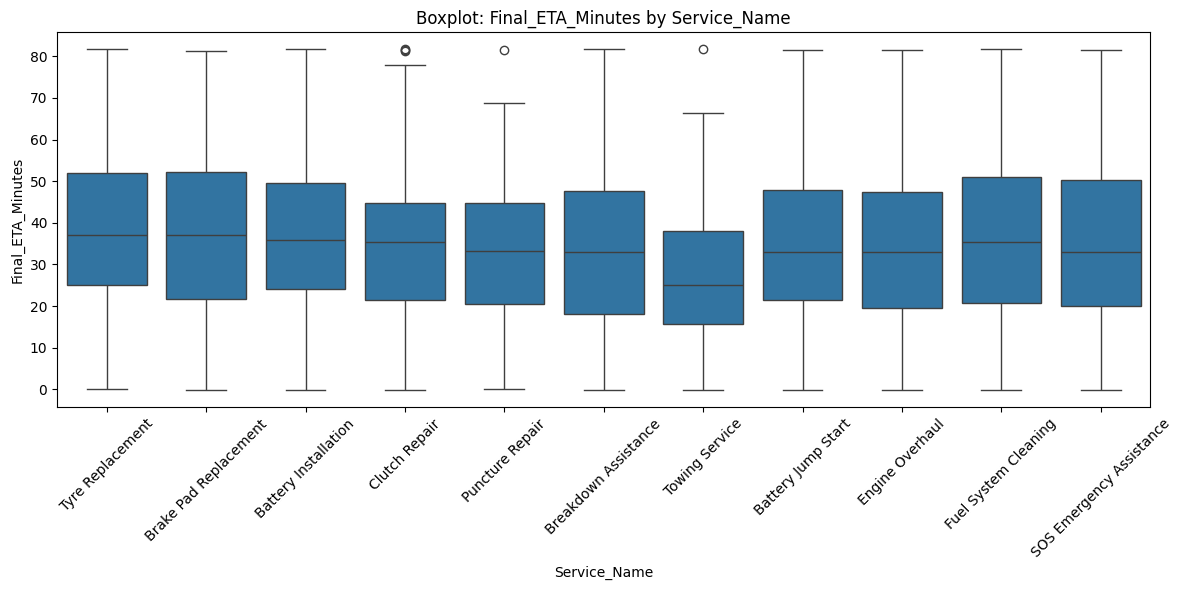

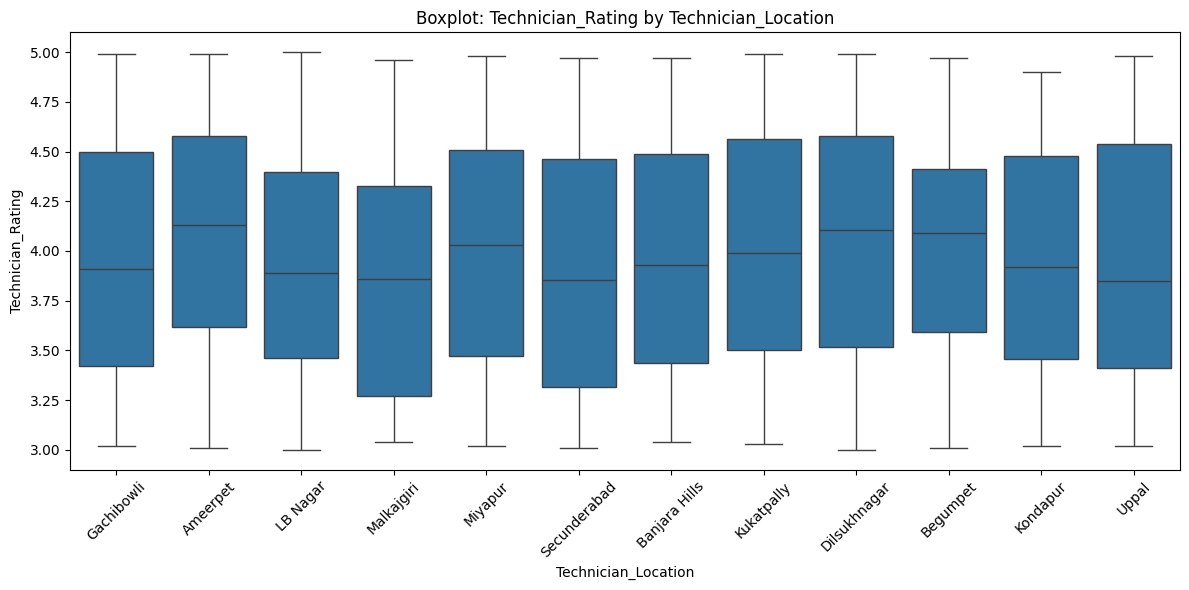

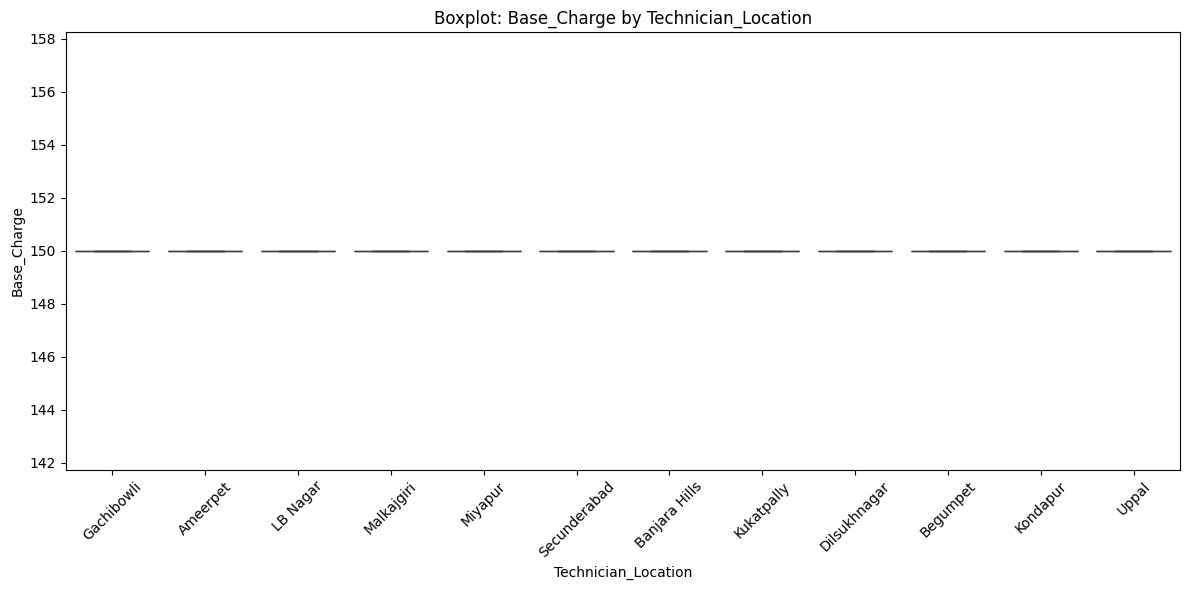

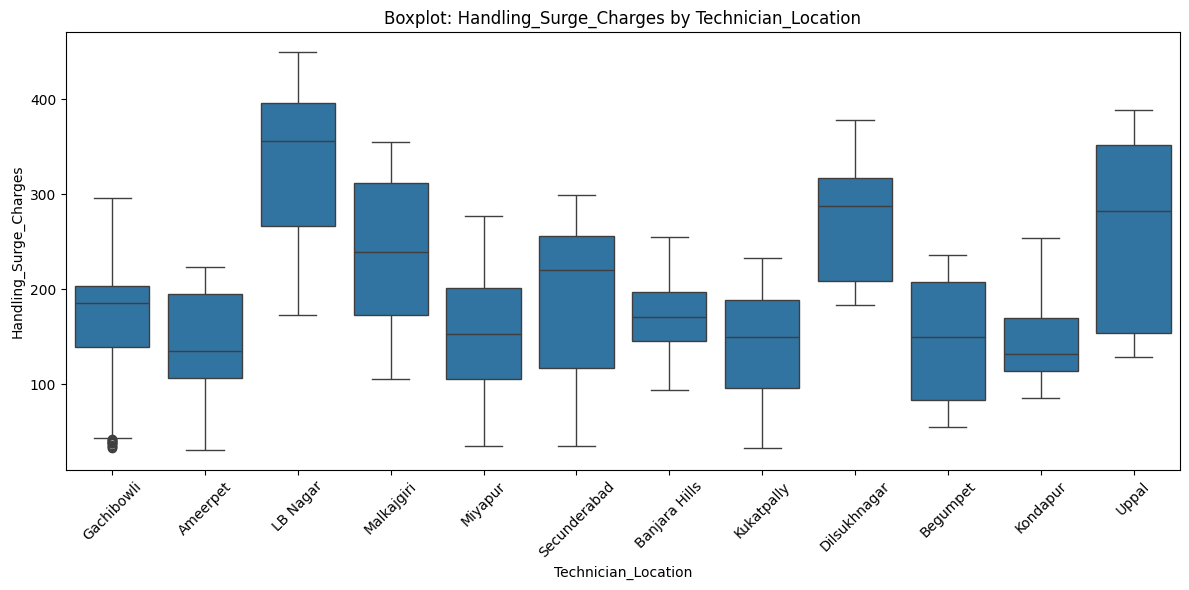

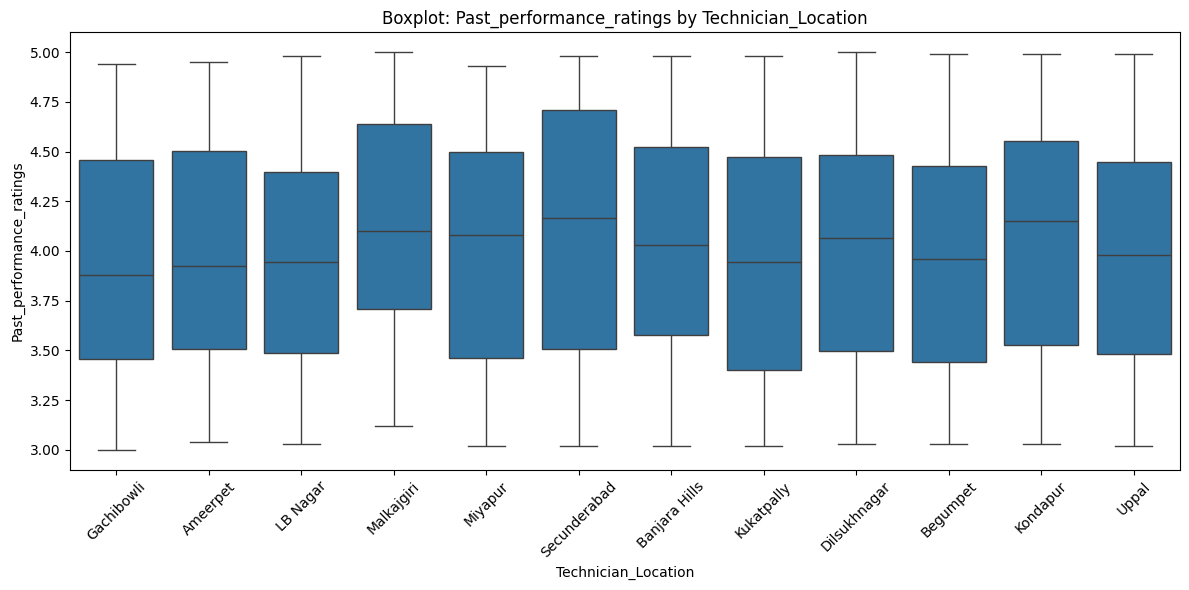

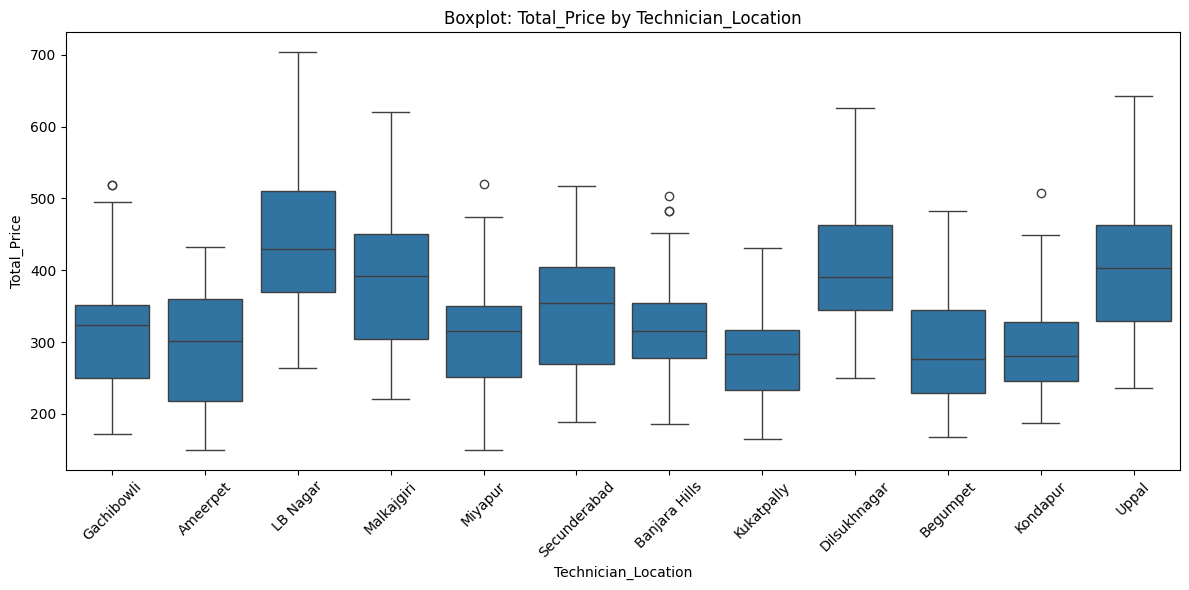

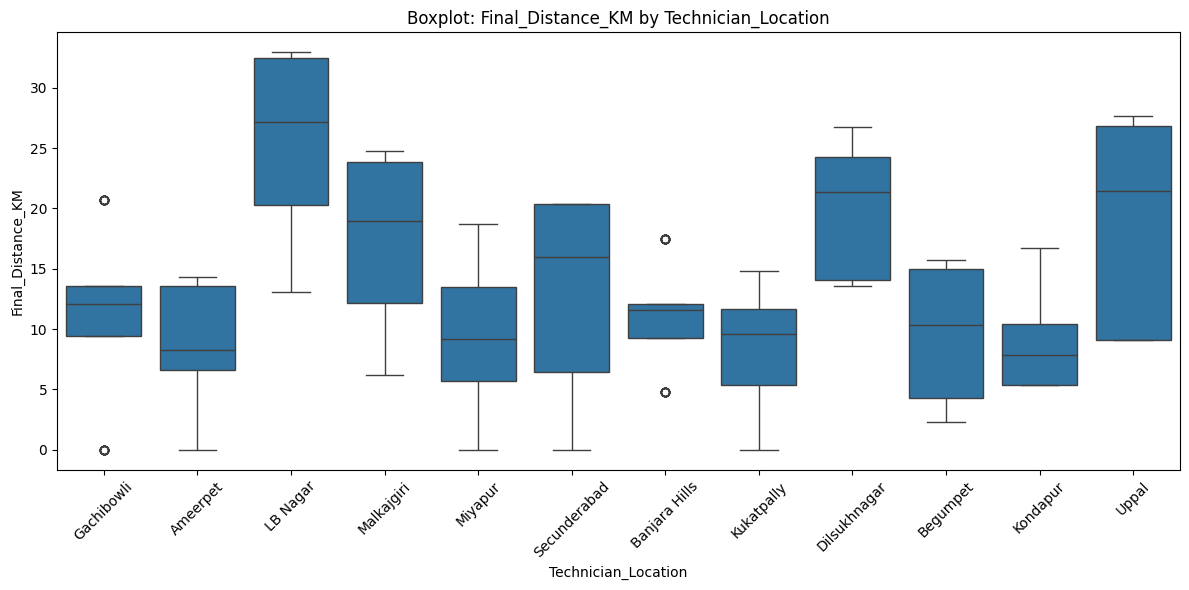

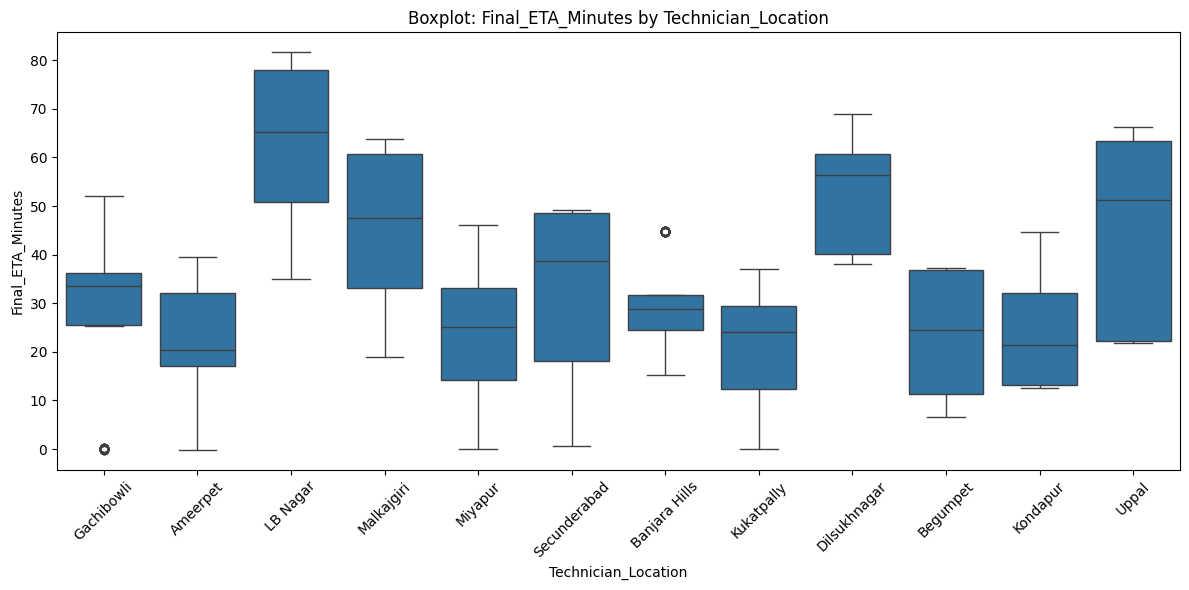

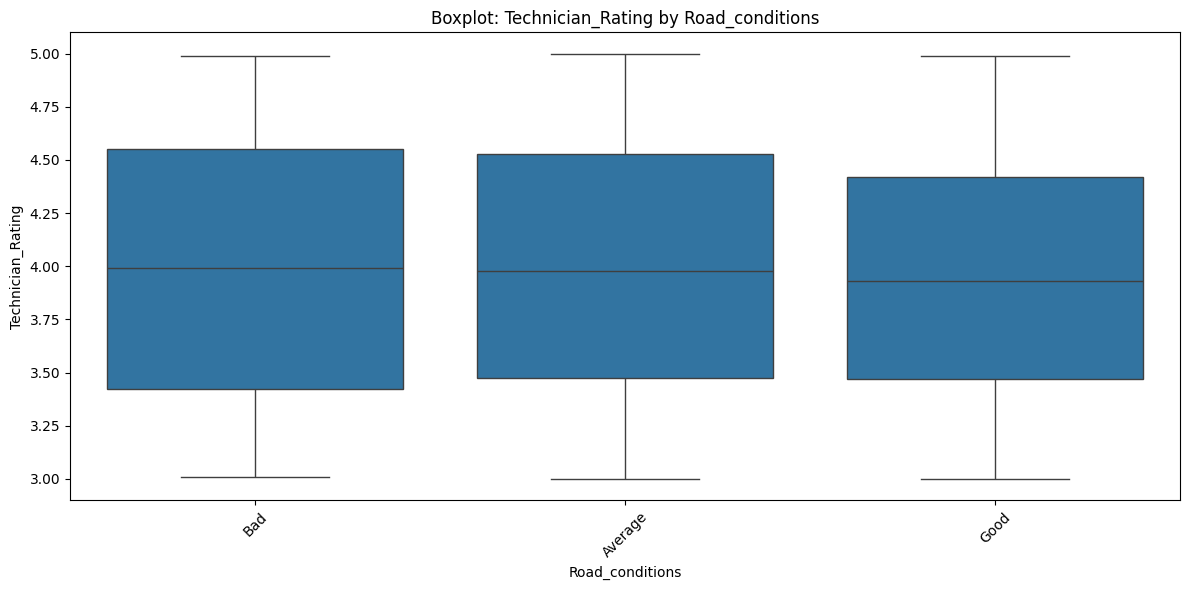

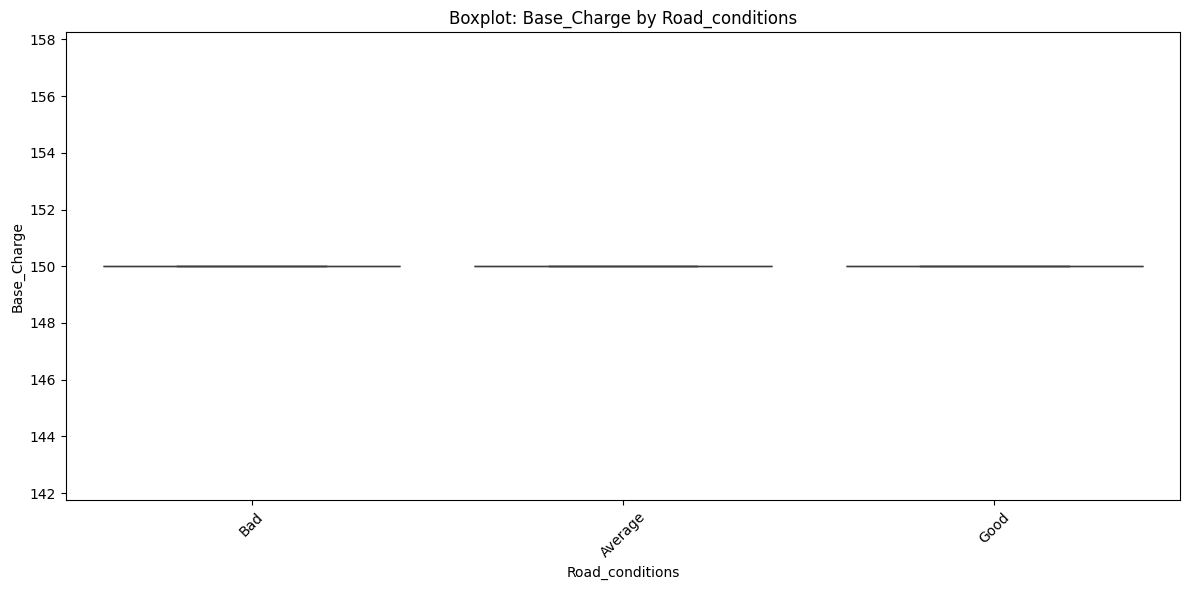

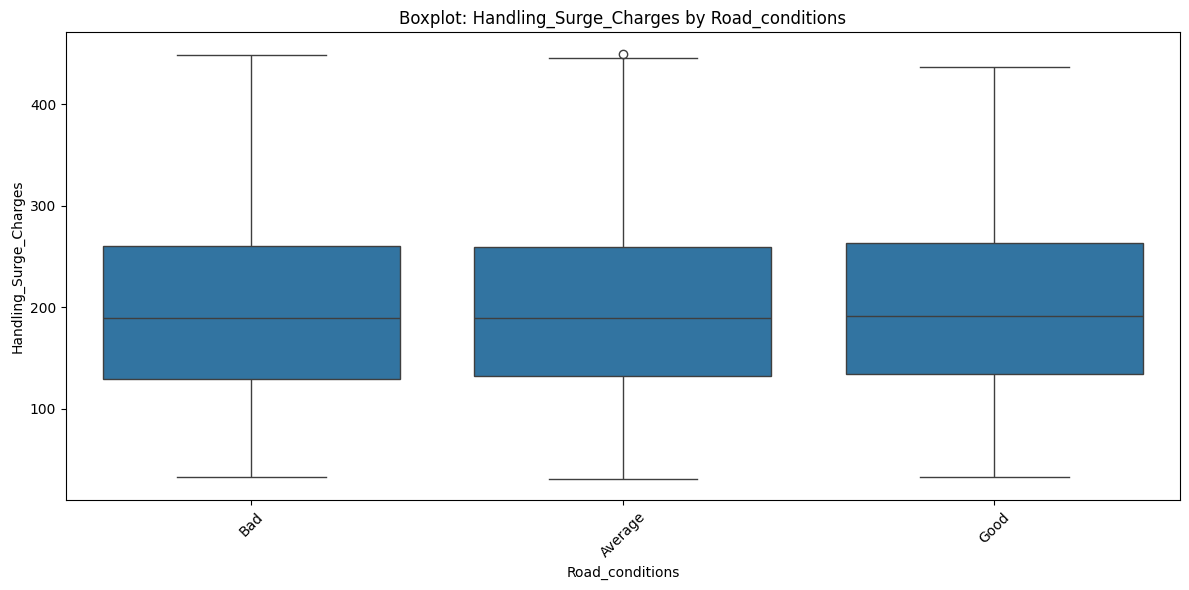

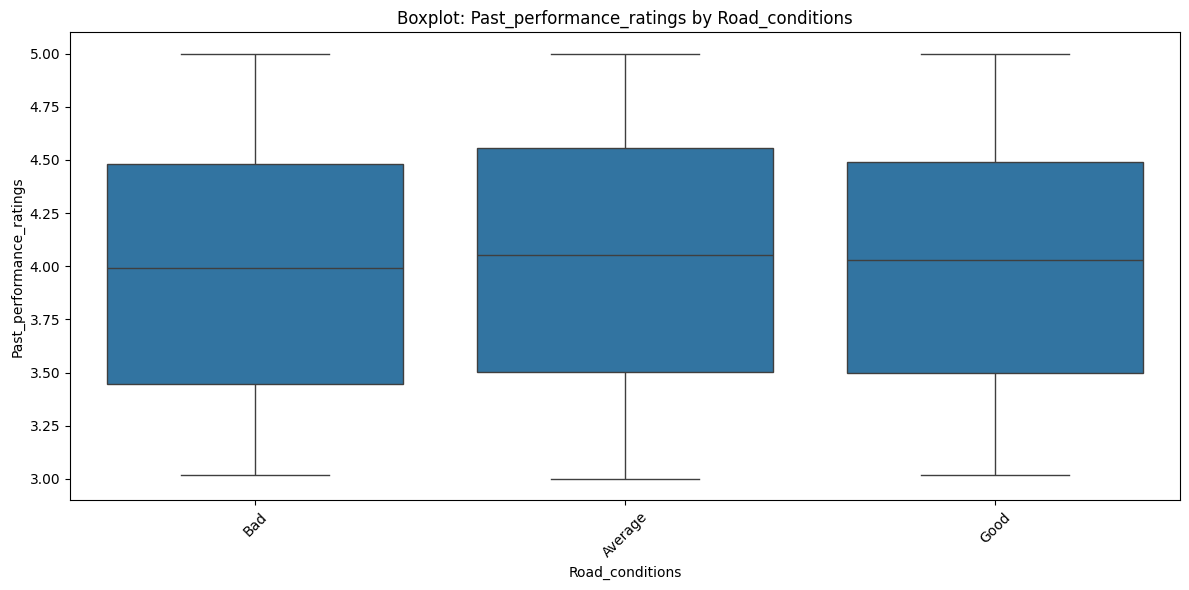

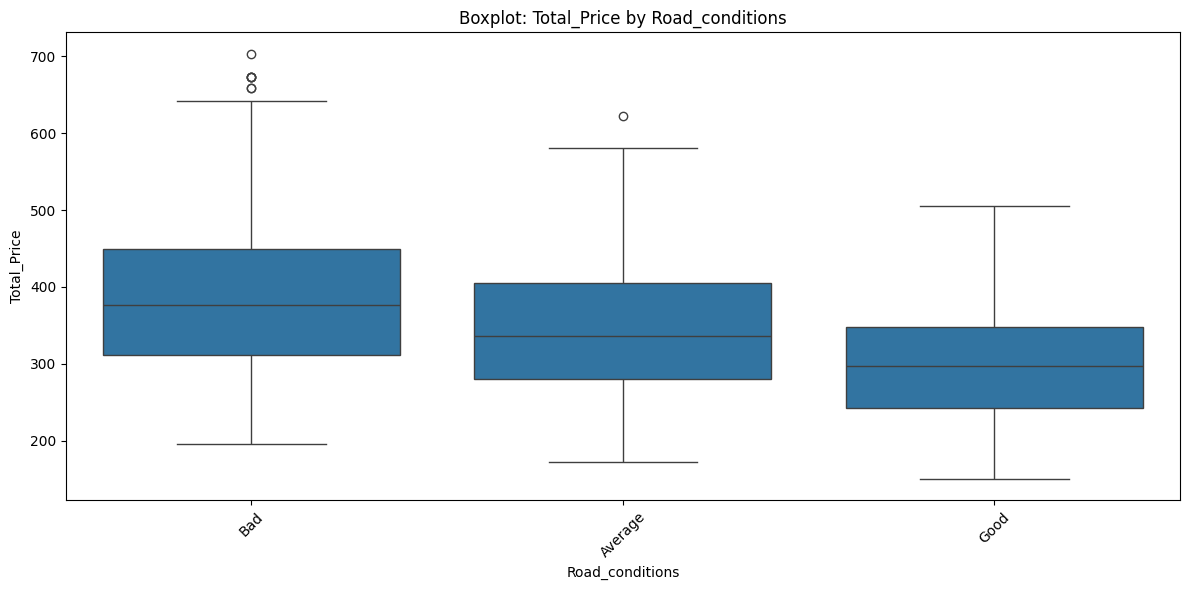

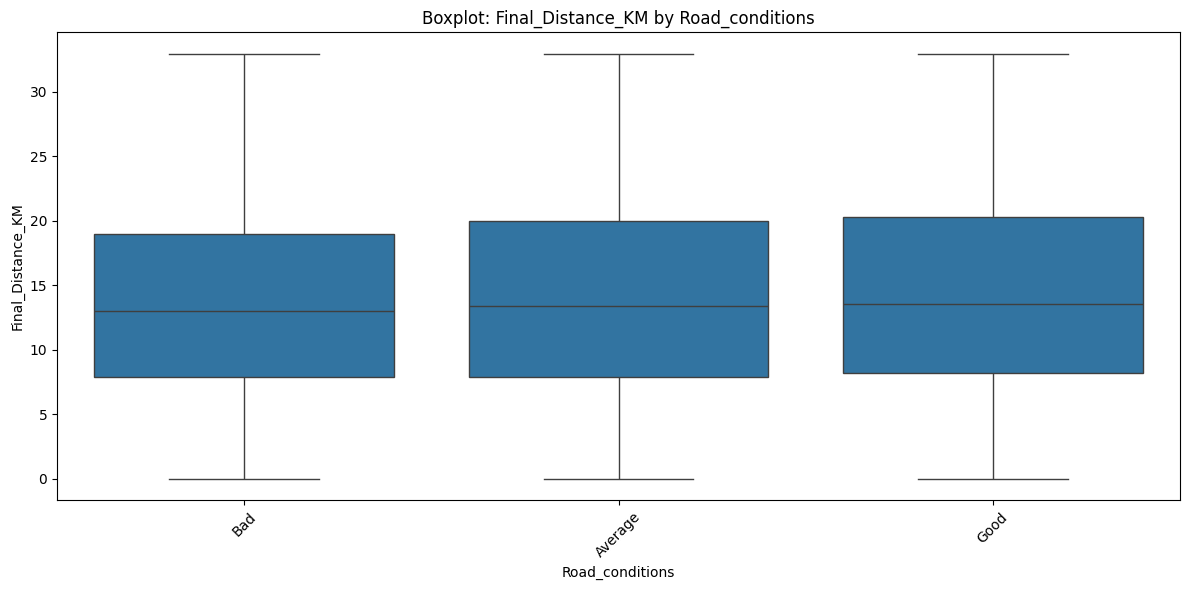

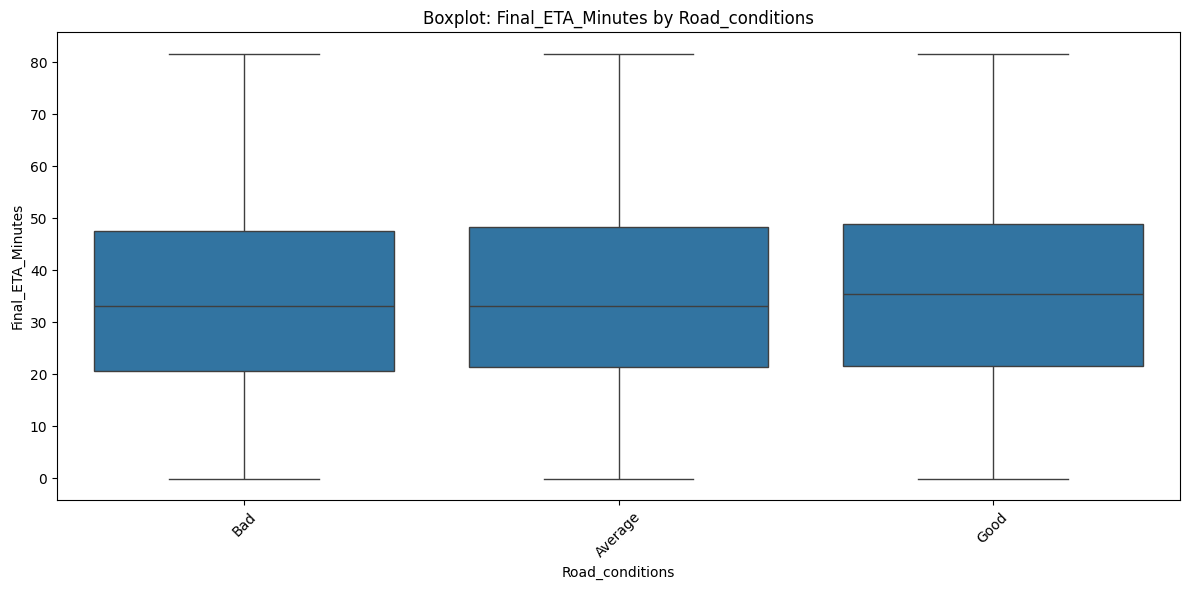

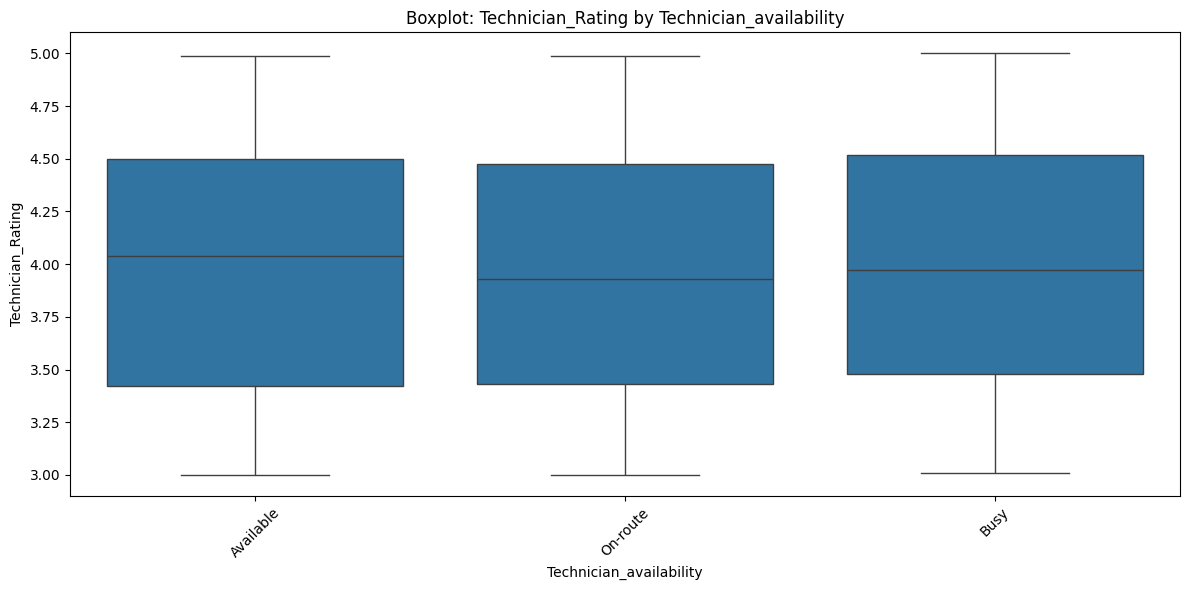

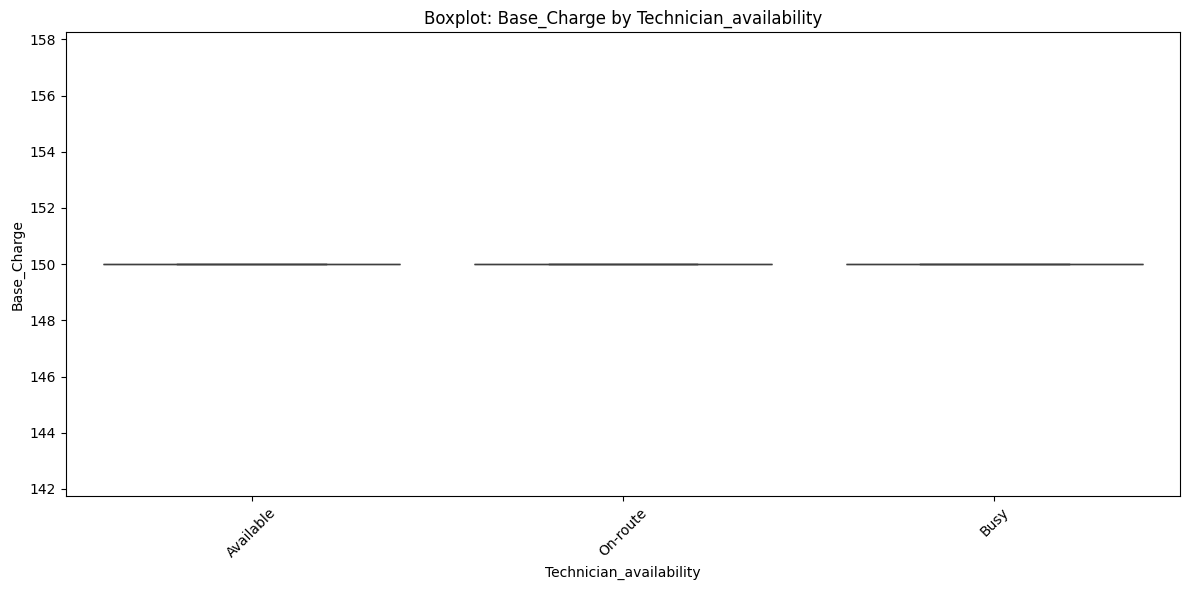

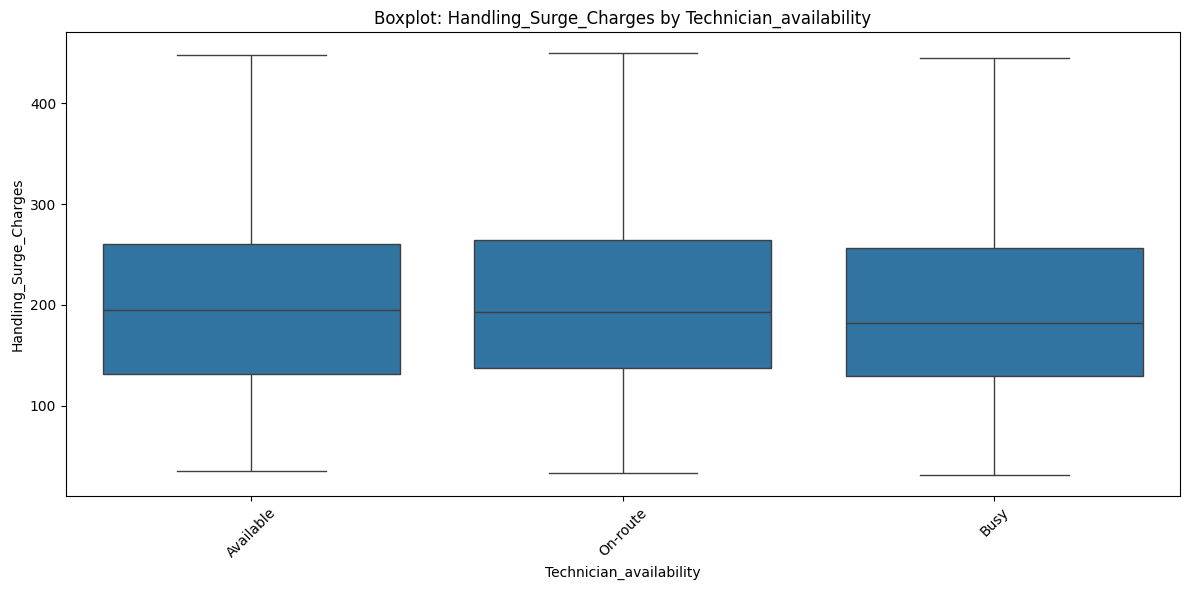

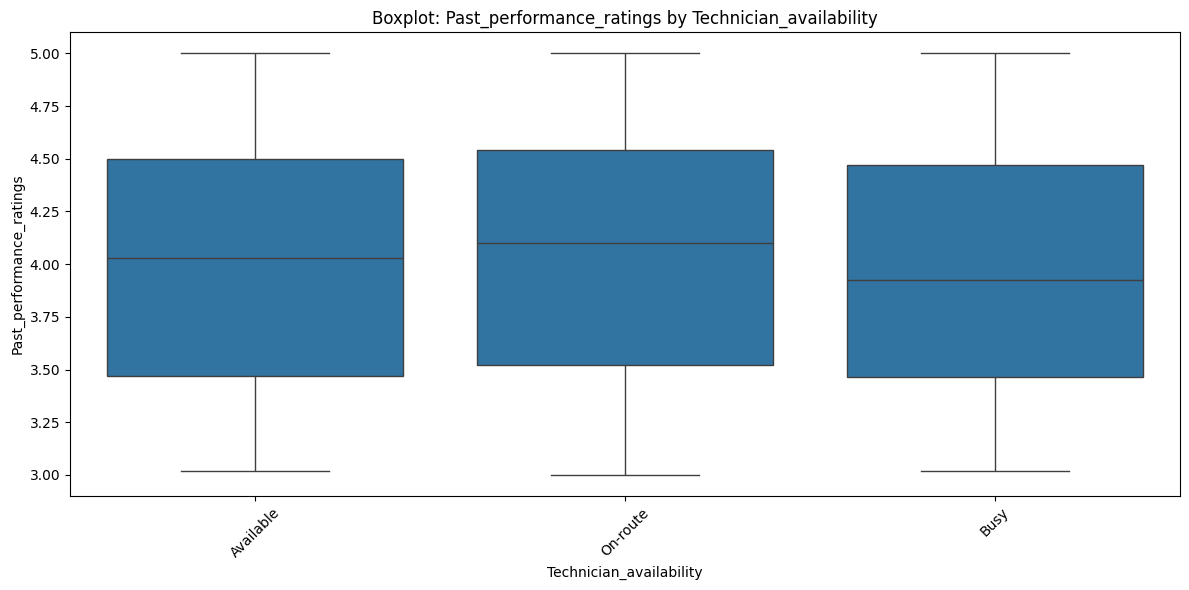

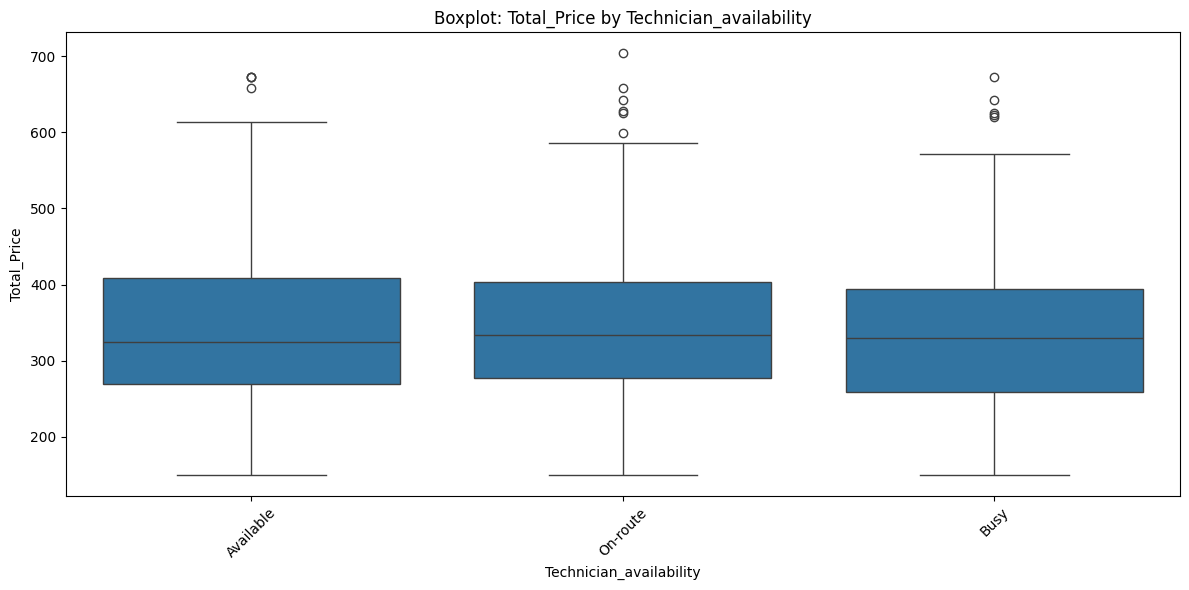

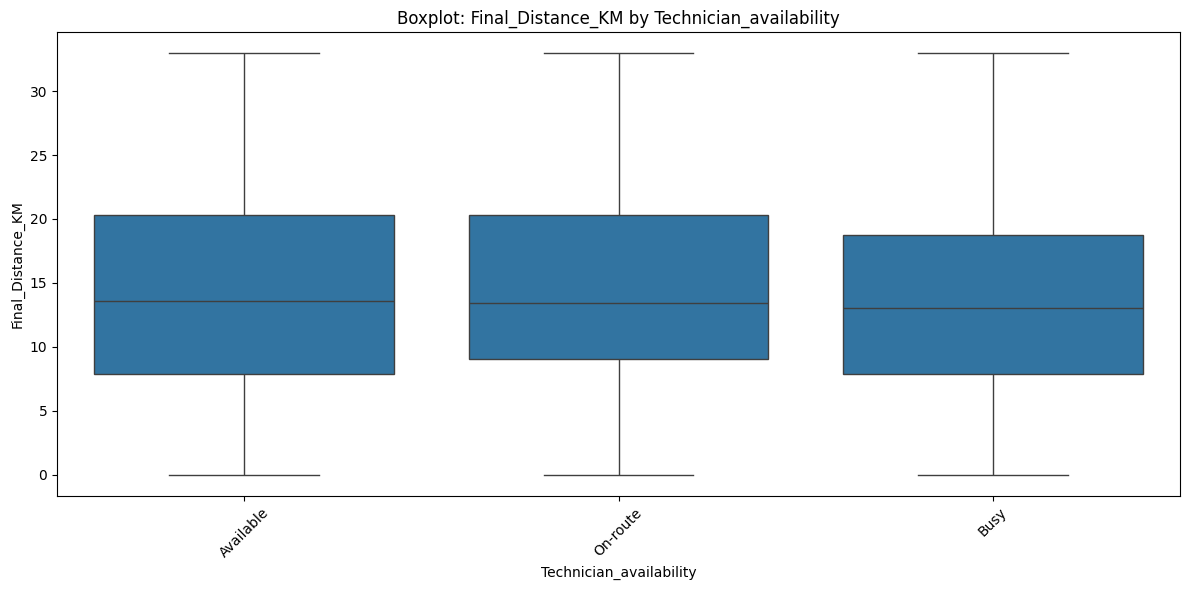

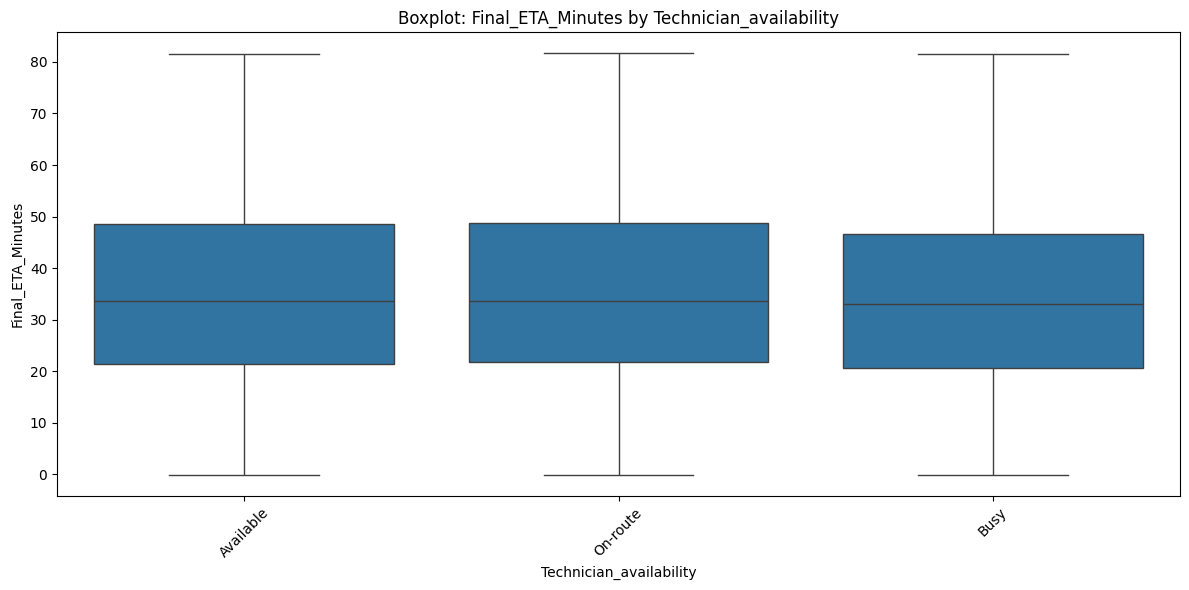

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = [
    "Service_Name",
    "Technician_Location",
    "Road_conditions",
    "Technician_availability",
]

num_cols = [
    "Technician_Rating",
    "Base_Charge",
    "Handling_Surge_Charges",
    "Past_performance_ratings",
    "Total_Price",
    "Final_Distance_KM",
    "Final_ETA_Minutes"
]

for cat in cat_cols:
    for num in num_cols:

        if cat not in df.columns or num not in df.columns:
            continue


        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x=cat, y=num)
        plt.title(f"Boxplot: {num} by {cat}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [ ]:
df.isna().sum()

,0
Request_ID,0
User_ID,0
User_Name,0
User_Phone,0
User_Location,0
User_to_Technician_Distance,0
Estimated_Delivery_Time,0
Vehicle_Company,0
Vehicle_Model,0
Model_Year,0


In [ ]:
df.shape

(1000, 38)

In [ ]:
numdata=df.select_dtypes(exclude="O")

In [ ]:
def Outlier_Identification(numdata):
    for col in numdata.columns:
        print("Column:", col)
        print()
        # quantiles
        q1 = numdata[col].quantile(0.25)
        q3 = numdata[col].quantile(0.75)
        # iqr
        iqr = q3-q1
        # ranges
        lowerbound = q1-(1.5*iqr)
        upperbound = q3+(1.5*iqr)

        lowerout = []
        upperout = []

        for val in numdata[col]:
            if val<lowerbound:
                lowerout.append(val)
            elif val>upperbound:
                upperout.append(val)

        lowerout.sort()
        upperout.sort()

        print("Lower Outliers:")
        print(lowerout)
        print()
        print("Total Number of Set of Lower Outliers:", len(set(lowerout)))
        print("Total Number of Lower Outliers:", len(lowerout))
        print()
        print("Upper Outliers:")
        print(upperout)
        print()
        print("Number of Set of Upper Outliers:", len(set(upperout)))
        print("Total Number of Upper Outliers:", len(upperout))
        print("===============================================")
        print()

In [ ]:
Outlier_Identification(numdata)

Column: User_Phone

Lower Outliers:
[]

Total Number of Set of Lower Outliers: 0
Total Number of Lower Outliers: 0

Upper Outliers:
[]

Number of Set of Upper Outliers: 0
Total Number of Upper Outliers: 0

Column: User_to_Technician_Distance

Lower Outliers:
[]

Total Number of Set of Lower Outliers: 0
Total Number of Lower Outliers: 0

Upper Outliers:
[]

Number of Set of Upper Outliers: 0
Total Number of Upper Outliers: 0

Column: Estimated_Delivery_Time

Lower Outliers:
[]

Total Number of Set of Lower Outliers: 0
Total Number of Lower Outliers: 0

Upper Outliers:
[]

Number of Set of Upper Outliers: 0
Total Number of Upper Outliers: 0

Column: Model_Year

Lower Outliers:
[]

Total Number of Set of Lower Outliers: 0
Total Number of Lower Outliers: 0

Upper Outliers:
[]

Number of Set of Upper Outliers: 0
Total Number of Upper Outliers: 0

Column: Spare_Part_Price

Lower Outliers:
[]

Total Number of Set of Lower Outliers: 0
Total Number of Lower Outliers: 0

Upper Outliers:
[]

Numb

In [ ]:
import plotly.express as px


In [ ]:
for col in numdata.columns:
    px.box(numdata[col], orientation='h', height=300, width=750, title=f"{col.title()} Boxplot").show()

## 2. Surge Prediction Model

##  Imports & File Paths

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge


DATA_IN = "//content/FixRoute_With_ETA_GB.xlsx"
OUT_RF = "/content/surge_rf_model.joblib"
OUT_XGB = "/content/surge_xgb_model.joblib"



##  Load Dataset

In [ ]:
df = pd.read_excel(DATA_IN)
print("Loaded:", df.shape)


Loaded: (1000, 38)


 ## Validate Required Columns and Defining X & Y

In [ ]:
required = [
    "Final_Distance_KM",
    "Final_ETA_Minutes",
    "Road_conditions",
    "Time_of_day",
    "Technician_availability",
    "Peak_hours",
    "Emergency_severity",
    "Technician_Rating",
    "Past_performance_ratings",
    "Distance_Hub_to_User_kms",
    "Road_Duration",
    "Service_Name",
    "Handling_Surge_Charges"
]

for c in required:
    if c not in df.columns:
        raise ValueError(f"Missing: {c}")

X = df[
    [
        "Final_Distance_KM",
        "Final_ETA_Minutes",
        "Technician_Rating",
        "Past_performance_ratings",
        "Service_Name"
    ]
]

y = df["Handling_Surge_Charges"]

X = X.copy()



##Ordinal Mapping

##Preprocessing Setup

In [ ]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = ["Service_Name"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", SimpleImputer(strategy="median"), numeric_cols)
    ]
)


##Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

## Model Selection

In [ ]:
rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=700,
        max_depth=28,
        min_samples_split=2,
        random_state=42
    ))
])

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("MAE :", mean_absolute_error(y_test, rf_pred))
print("R2  :", r2_score(y_test, rf_pred))

joblib.dump(rf, OUT_RF)


MAE : 8.7389194960851
R2  : 0.985634837511242


['/content/surge_rf_model.joblib']

In [ ]:
models = {
    "XGBoost": XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ),

    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ),

    "LinearRegression": LinearRegression(),

    "RidgeRegression": Ridge(alpha=1.0)
}

trained_models = {}
results = []



for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": rmse,
        "R2": r2_score(y_test, preds)
    })

    trained_models[name] = pipe


results_df = pd.DataFrame(results)
print(results_df)

              Model       MAE       RMSE        R2
0           XGBoost  8.792853  11.556510  0.985780
1      RandomForest  8.764764  11.673534  0.985491
2  LinearRegression  7.944683  10.396210  0.988492
3   RidgeRegression  7.945922  10.394655  0.988496


In [ ]:
best = results_df.sort_values("MAE").iloc[0]["Model"]
joblib.dump(trained_models[best], "best_eta_model.joblib")
print("Best Model Saved:", best)

Best Model Saved: LinearRegression


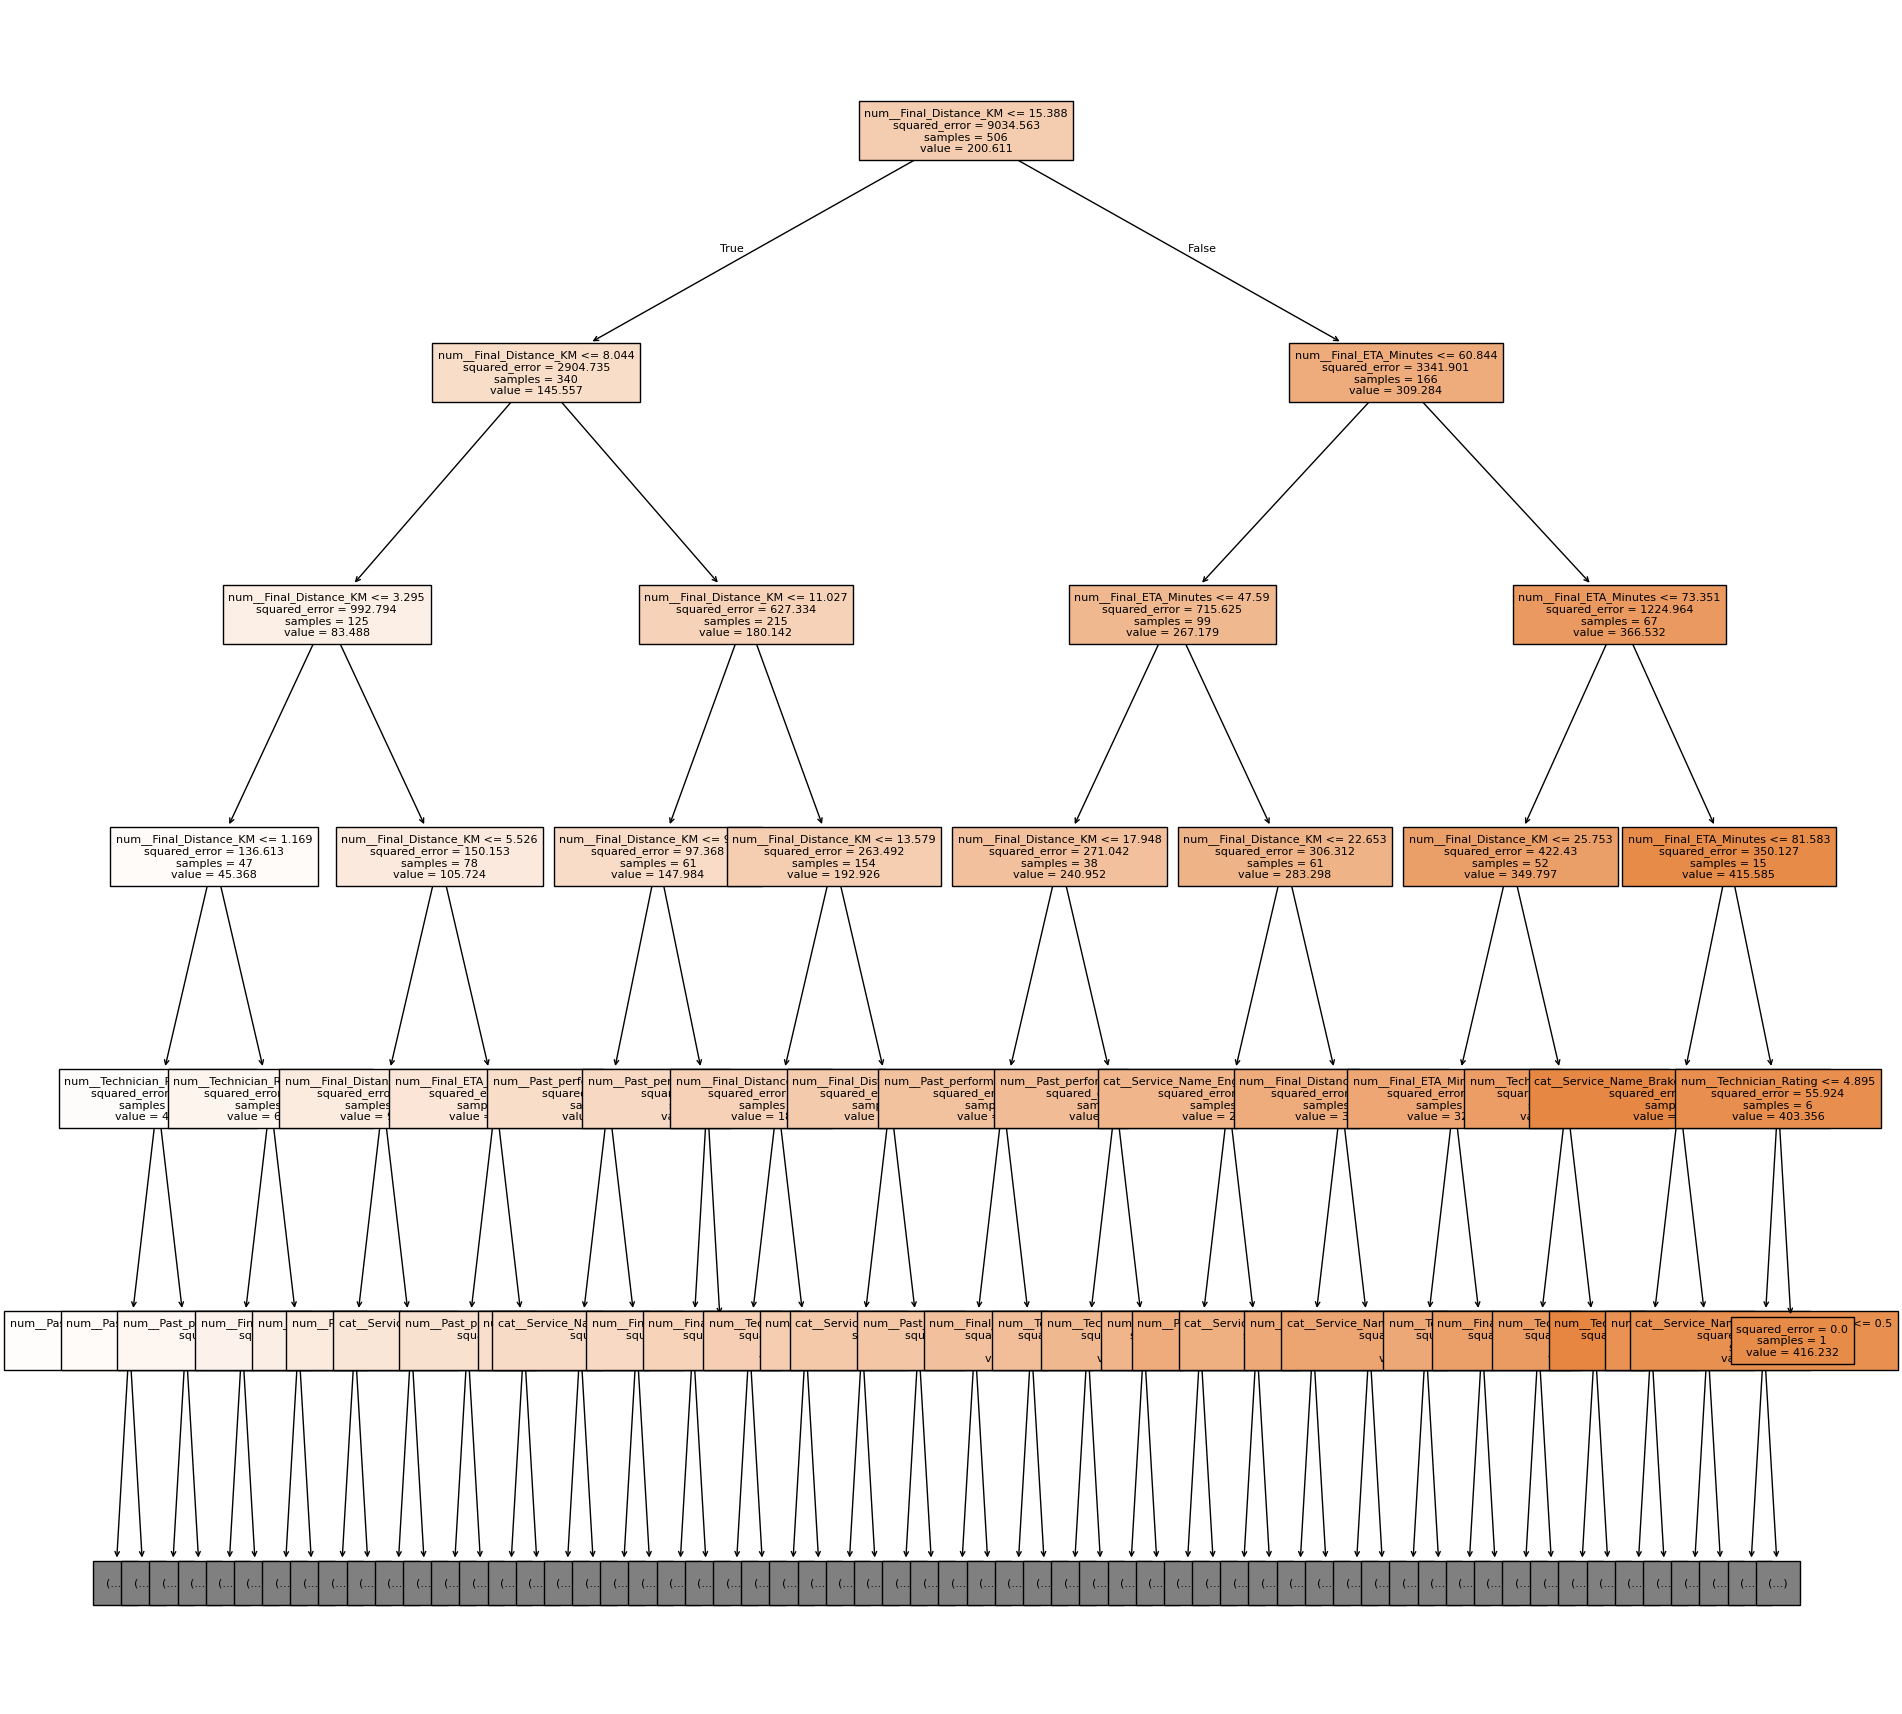

In [ ]:
from sklearn.tree import plot_tree

rf_model = rf.named_steps["model"]
preprocessor = rf.named_steps["prep"]
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = None

plt.figure(figsize=(22, 22))
plot_tree(
    rf_model.estimators_[0],
    filled=True,
    feature_names=feature_names,
    max_depth=5,
    fontsize=8
)
plt.show()


##Final Pricing Model

In [ ]:
import joblib
import pandas as pd

class FinalPriceModel:
    def __init__(self, surge_model_path):

        self.surge_model = joblib.load(surge_model_path)

    def predict_total(self, input_data, base_charge, spare_part_price=0):


        df = pd.DataFrame([input_data])

        surge = self.surge_model.predict(df)[0]

        final_price = base_charge + surge + spare_part_price

        return {
            "predicted_surge_charge": round(float(surge), 2),
            "final_total_price": round(float(final_price), 2)
        }


In [ ]:
final_model = FinalPriceModel("/content/xgboost_model.joblib")

joblib.dump(final_model, "/content/final_price_model.joblib")
print("Final price model saved successfully!")


Final price model saved successfully!


EXAMPLE USAGE

In [ ]:
import joblib

# Load unified model
model = joblib.load("/content/final_price_model.joblib")

example_input = {
    "Final_Distance_KM": 12.6,
    "Final_ETA_Minutes": 28.4,
    "Road_conditions": 2,
    "Time_of_day": 19,
    "Technician_availability": 1,
    "Peak_hours": 1,
    "Emergency_severity": 2,
    "Technician_Rating": 4.5,
    "Past_performance_ratings": 4.1,
    "Service_Name": "Engine Repair"
}

result = model.predict_total(
    input_data=example_input,
    base_charge=350,
    spare_part_price= 1200
)

print(result)


{'predicted_surge_charge': 171.66, 'final_total_price': 1721.66}


In [ ]:
import joblib
import pandas as pd

surge_model = joblib.load("/content/xgboost_model.joblib")


print("\n===== ENTER INPUTS FOR SURGE CALCULATION =====\n")

Final_Distance_KM = float(input("Enter Final Distance (KM): "))
Final_ETA_Minutes = float(input("Enter Final ETA (Minutes): "))
Technician_Rating = float(input("Technician Rating: "))
Past_performance_ratings = float(input("Past Performance Rating: "))

Service_Name = input("Service Name: ")

base_charge = float(input("Base Charge: "))

use_spare = input("Is Spare Part Used? (Yes/No): ")

if use_spare.lower() == "yes":
    spare_part_price = float(input("Enter Spare Part Price: "))
else:
    spare_part_price = 0


input_data = {
    "Final_Distance_KM": Final_Distance_KM,
    "Final_ETA_Minutes": Final_ETA_Minutes,
    "Technician_Rating": Technician_Rating,
    "Past_performance_ratings": Past_performance_ratings,
    "Service_Name": Service_Name
}

df_input = pd.DataFrame([input_data])

predicted_surge = surge_model.predict(df_input)[0]
predicted_surge = round(float(predicted_surge), 2)

final_price = base_charge + predicted_surge + spare_part_price


print("\n================= RESULT =================")
print("Predicted Surge Charge      :", predicted_surge)
print("Base Charge                 :", base_charge)
print("Spare Part Price            :", spare_part_price)
print("------------------------------------------")
print("FINAL TOTAL PRICE           :", round(final_price, 2))
print("==========================================")



===== ENTER INPUTS FOR SURGE CALCULATION =====

Enter Final Distance (KM): 10
Enter Final ETA (Minutes): 20
Technician Rating: 0
Past Performance Rating: 0
Service Name: engine overhual
Base Charge: 100
Is Spare Part Used? (Yes/No): no

================= RESULT =================
Predicted Surge Charge      : 127.53
Base Charge                 : 100.0
Spare Part Price            : 0
------------------------------------------
FINAL TOTAL PRICE           : 227.53
